In [ ]:
!pip install tensorflow-io
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
###
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import ResNet50
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/BoneFractureWork/OurDataset/Multiclass/OurDataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: OurDataset/Wrist/Negative/Train/651.png  
  inflating: OurDataset/Wrist/Negative/Train/652.png  
  inflating: OurDataset/Wrist/Negative/Train/653.png  
  inflating: OurDataset/Wrist/Negative/Train/654.png  
  inflating: OurDataset/Wrist/Negative/Train/655.png  
  inflating: OurDataset/Wrist/Negative/Train/656.png  
  inflating: OurDataset/Wrist/Negative/Train/657.png  
  inflating: OurDataset/Wrist/Negative/Train/658.png  
  inflating: OurDataset/Wrist/Negative/Train/659.png  
  inflating: OurDataset/Wrist/Negative/Train/660.png  
  inflating: OurDataset/Wrist/Negative/Train/661.png  
  inflating: OurDataset/Wrist/Negative/Train/662.png  
  inflating: OurDataset/Wrist/Negative/Train/663.png  
  inflating: OurDataset/Wrist/Negative/Train/664.png  
  inflating: OurDataset/Wrist/Negative/Train/665.png  
  inflating: OurDataset/Wrist/Negative/Train/666.png  
  inflating: OurDataset/Wrist/Negative/Train/667.png  
  inflating: O

In [ ]:
Path= "/content/OurDataset/"
Path = pathlib.Path(Path)
Path

PosixPath('/content/OurDataset')

In [ ]:
FracturedElbow = list(Path.glob('Elbow/Positive/*/*.png'))
NonFracturedElbow = list(Path.glob('Elbow/Negative/*/*.png'))
FracturedFinger = list(Path.glob('Finger/Positive/*/*.png'))
NonFracturedFinger = list(Path.glob('Finger/Negative/*/*.png'))
FracturedForearm = list(Path.glob('Forearm/Positive/*/*.png'))
NonFracturedForearm = list(Path.glob('Forearm/Negative/*/*.png'))
FracturedHand = list(Path.glob('Hand/Positive/*/*.png'))
NonFracturedHand= list(Path.glob('Hand/Negative/*/*.png'))
FracturedHumerus= list(Path.glob('Humerus/Positive/*/*.png'))
NonFracturedHumerus = list(Path.glob('Humerus/Negative/*/*.png'))
FracturedShoulder = list(Path.glob('Shoulder/Positive/*/*.png'))
NonFracturedShoulder = list(Path.glob('Shoulder/Negative/*/*.png'))
FracturedWrist = list(Path.glob('Wrist/Positive/*/*.png'))
NonFracturedWrist = list(Path.glob('Wrist/Negative/*/*.png'))

boneFracture= [FracturedElbow, NonFracturedElbow, FracturedFinger, NonFracturedFinger, FracturedForearm, NonFracturedForearm, FracturedHand, 
         NonFracturedHand, FracturedHumerus, NonFracturedHumerus, FracturedShoulder, NonFracturedShoulder, FracturedWrist, NonFracturedWrist]
boneFracture_classes = ['FracturedElbow', 'NonFracturedElbow', 'FracturedFinger', 'NonFracturedFinger', 'FracturedForearm', 'NonFracturedForearm', 'FracturedHand', 
         'NonFracturedHand', 'FracturedHumerus', 'NonFracturedHumerus', 'FracturedShoulder', 'NonFracturedShoulder', 'FracturedWrist', 'NonFracturedWrist']

print(boneFracture_classes)


['FracturedElbow', 'NonFracturedElbow', 'FracturedFinger', 'NonFracturedFinger', 'FracturedForearm', 'NonFracturedForearm', 'FracturedHand', 'NonFracturedHand', 'FracturedHumerus', 'NonFracturedHumerus', 'FracturedShoulder', 'NonFracturedShoulder', 'FracturedWrist', 'NonFracturedWrist']


Total images: 40005
Total number of classes: 14
Total FracturedElbow images: 2236
Total NonFracturedElbow images: 3160
Total FracturedFinger images: 2215
Total NonFracturedFinger images: 3352
Total FracturedForearm images: 812
Total NonFracturedForearm images: 1314
Total FracturedHand images: 1673
Total NonFracturedHand images: 4330
Total FracturedHumerus images: 739
Total NonFracturedHumerus images: 821
Total FracturedShoulder images: 4446
Total NonFracturedShoulder images: 4496
Total FracturedWrist images: 4282
Total NonFracturedWrist images: 6129


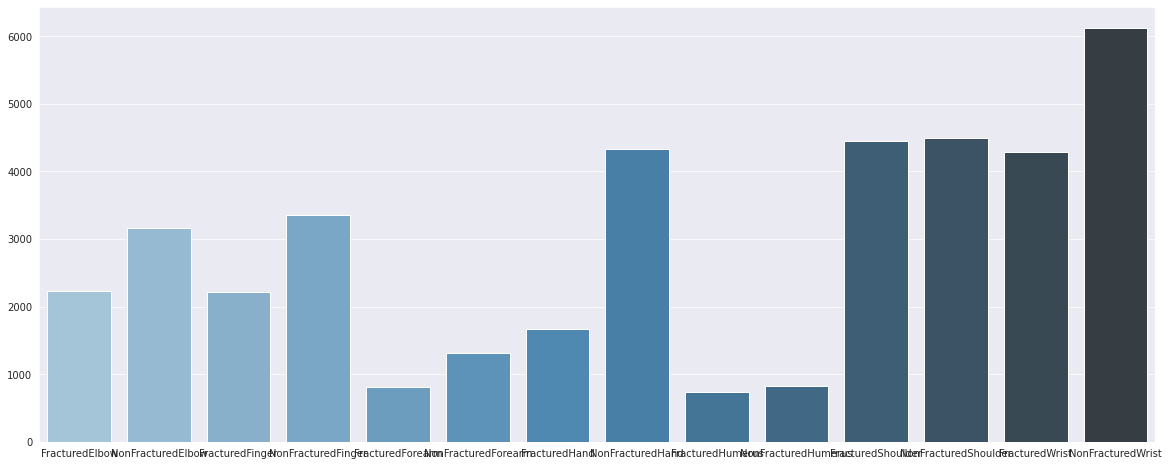

In [ ]:
Path= "/content/OurDataset/"
Path = pathlib.Path(Path)
image_count = len(list(Path.glob('*/*/*/*.png')))

print(f'Total images: {image_count}')
print(f'Total number of classes: {len(boneFracture_classes)}')
count = 0
boneFracture_count = []
for x in boneFracture_classes:
  print(f'Total {x} images: {len(boneFracture[count])}')
  boneFracture_count.append(len(boneFracture[count]))
  count += 1

sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
sns.barplot(x=boneFracture_classes, y=boneFracture_count, palette="Blues_d")
plt.show()


In [ ]:
# function
import  cv2
import imgaug
import imageio
import os
import numpy as np
from imgaug import augmenters as iaa

class DataAugmentation:
	def __init__(self, root_dir="",output_dir=""):
		self.root_dir = root_dir
		self.output_dir = output_dir
		print("Instance of the DataAugmentation class created")

	def augmentation_of_image(self, test_image, output_path):
		self.test_image = test_image;
		self.output_path = output_path;
		#define the Augmenters

		#properties: A range of values signifies that one of these numbers is randmoly chosen for every augmentation for every batch

		# Apply affine transformations to each image.
		rotate = iaa.Affine(rotate=(-90,90));  
		scale = iaa.Affine(scale={"x": (0.5, 0.9), "y": (0.5,0.9)}); 
		translation = iaa.Affine(translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)});
		shear = iaa.Affine(shear=(-2, 2)); #plagio parallhlogrammo wihthin a range (-8,8)
		zoom = iaa.PerspectiveTransform(scale=(0.01, 0.15), keep_size=True) # do not change the output size of the image
		h_flip = iaa.Fliplr(1.0); # flip horizontally all images (100%)
		v_flip = iaa.Flipud(1.0); #flip vertically all images
		padding=iaa.KeepSizeByResize(iaa.CropAndPad(percent=(0.05, 0.25)))#positive values correspond to padding 5%-25% of the image,but keeping the origial output size of the new image


		#More augmentations
		blur = iaa.GaussianBlur(sigma=(0, 1.22)) # blur images with a sigma 0-2,a number ofthis range is randomly chosen everytime.Low values suggested for this application
		contrast = iaa.contrast.LinearContrast((0.75, 1.5)); #change the contrast by a factor of 0.75 and 1.5 sampled randomly per image
		contrast_channels = iaa.LinearContrast((0.75, 1.5), per_channel=True) #and for 50% of all images also independently per channel:
		sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)); #sharpen with an alpha from 0(no sharpening) - 1(full sharpening) and change the lightness form 0.75 to 1.5 
		gauss_noise = iaa.AdditiveGaussianNoise(scale=0.111*255, per_channel=True) #some random gaussian noise might occur in cell images,especially when image quality is poor
		laplace_noise = iaa.AdditiveLaplaceNoise(scale=(0, 0.111*255)) #we choose to be in a small range, as it is logical for training the cell images


		#Brightness 
		brightness = iaa.Multiply((0.35,1.65)) #change brightness between 35% or 165% of the original image
		brightness_channels = iaa.Multiply((0.5, 1.5), per_channel=0.75) # change birghtness for 25% of images.For the remaining 75%, change it, but also channel-wise.

		#CHANNELS (RGB)=(Red,Green,Blue)
		red =iaa.WithChannels(0, iaa.Add((10, 100))) #increase each Red-pixels value within the range 10-100
		red_rot = iaa.WithChannels(0,iaa.Affine(rotate=(0, 45))) #rotate each image's red channel by 0-45 degrees
		green= iaa.WithChannels(1, iaa.Add((10, 100)))#increase each Green-pixels value within the range 10-100
		green_rot=iaa.WithChannels(1,iaa.Affine(rotate=(0, 45))) #rotate each image's green channel by 0-45 degrees
		blue=iaa.WithChannels(2, iaa.Add((10, 100)))#increase each Blue-pixels value within the range 10-100
		blue_rot=iaa.WithChannels(2,iaa.Affine(rotate=(0, 45))) #rotate each image's blue channel by 0-45 degrees

		#colors
		channel_shuffle =iaa.ChannelShuffle(1.0); #shuffle all images of the batch
		grayscale = iaa.Grayscale(1.0)
		hue_n_saturation = iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True) #change hue and saturation with this range of values for different values 
		add_hue_saturation = iaa.AddToHueAndSaturation((-50, 50), per_channel=True) #add more hue and saturation to its pixels
		#Quantize colors using k-Means clustering
		kmeans_color = iaa.KMeansColorQuantization(n_colors=(4, 16)) #quantizes to k means 4 to 16 colors (randomly chosen). Quantizes colors up to 16 colors

		#Alpha Blending 
		blend =iaa.AlphaElementwise((0, 1.0), iaa.Grayscale((0,1.0))) ; #blend depending on which value is greater

		#Contrast augmentors
		clahe = iaa.CLAHE(tile_grid_size_px=((3, 21),[0,2,3,4,5,6,7])) #create a clahe contrast augmentor H=(3,21) and W=(0,7)
		histogram = iaa.HistogramEqualization() #performs histogram equalization

		#Augmentation list of metadata augmentors
		OneofRed = iaa.OneOf( [red]);
		OneofGreen = iaa.OneOf( [green] );
		OneofBlue = iaa.OneOf( [blue]);
		contrast_n_shit = iaa.OneOf([contrast, brightness, brightness_channels]);
		SomeAug = iaa.SomeOf(2,[rotate,scale, translation, shear, h_flip,v_flip],random_order=True);
		SomeClahe = iaa.SomeOf(2, [clahe, iaa.CLAHE(clip_limit=(1, 10)),iaa.CLAHE(tile_grid_size_px=(3, 21)),iaa.GammaContrast((0.5, 2.0)), iaa.AllChannelsCLAHE() , iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)],random_order=True) #Random selection from clahe augmentors
		edgedetection= iaa.OneOf([iaa.EdgeDetect(alpha=(0, 0.7)),iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0))]);# Search in some images either for all edges or for directed edges.These edges are then marked in a black and white image and overlayed with the original image using an alpha of 0 to 0.7.
		canny_filter = iaa.OneOf([iaa.Canny(), iaa.Canny(alpha=(0.5, 1.0), sobel_kernel_size=[3, 7])]); #choose one of the 2 canny filter options
		OneofNoise = iaa.OneOf([blur, gauss_noise, laplace_noise])
		Color_1 = iaa.OneOf([channel_shuffle,grayscale, hue_n_saturation , add_hue_saturation, kmeans_color]);
		Color_2 = iaa.OneOf([channel_shuffle,grayscale, hue_n_saturation , add_hue_saturation, kmeans_color]);
		Flip = iaa.OneOf([histogram , v_flip, h_flip]);

		#Define the augmentors used in the DA
		Augmentors= [SomeAug, SomeClahe, edgedetection, canny_filter, Color_1, contrast_n_shit]


		for i in range(0,6):
			img = cv2.imread(test_image) #read you image
			images = np.array([img for _ in range(6)], dtype=np.uint8)  # 12 is the size of the array that will hold 8 different images
			images_aug = Augmentors[i].augment_images(images)  #alternate between the different augmentors for a test image
			cv2.imwrite(os.path.join(output_path,test_image +"new"+str(i)+'.png'), images_aug[i])  #write all changed images
			
			

In [ ]:
import shutil
class DataAugmentation_Extension:
    def __init__(self, directory=""):
      self.directory = directory
      print("Instance of DataAugmentation_Extension class created")
    def printnow(self, dir):
      pass
      # print("Just testing that the method calling is working "+ dir)
    
    def extend_dataset(self, directory):
      # print("HEY")
      library_augment= DataAugmentation();
      self.directory = directory 

      if not os.path.exists(self.directory):
        print("ERROR! Couldn't find directory!")
      else:
        print("Directory exists")
      class_path = directory
      class_files = [class_path+name for name in os.listdir(class_path)]
      # print(class_files) #call augmentation for all class_files
      for i in range(len(class_files)):
        library_augment.augmentation_of_image(class_files[i], class_path)
        

In [ ]:
# for file in os.listdir("/content/OurDataset/Elbow/Negative/Train/"):
#   classes_path = os.path.join("/content/OurDataset/Elbow/Negative/Train/", file)
#   print(classes_path)
#   # class_files = [name for name in glob.glob(os.path.join(classes_path,'*.bmp'))]
#   # print(class_files)


In [ ]:
# dir = "/content/OurDataset/Elbow/Negative/Train/"
# class_files = [dir+name for name in os.listdir(dir)]
# class_files

In [ ]:
# #data augmentation
# #directories
# target_directory = "/content/OurDataset/Elbow/Negative/Train/"
# #create an instance of the class
# datasetda = DataAugmentation_Extension()
# datasetda.extend_dataset(target_directory)

In [ ]:
# len(os.listdir("/content/OurDataset/Elbow/Negative/Train/"))

In [ ]:
# Bones = ["Forearm", "Humerus"]
# Type = ["Positive", "Negative"]

# for bone in Bones:
#   for types in Type:
#     target_directory = "/content/OurDataset/"+bone+"/"+types+"/Train/"
#     #create an instance of the class
#     datasetda = DataAugmentation_Extension()
#     datasetda.extend_dataset(target_directory)

In [ ]:
def augment_data(Bone, Type):
  Sets = ["Train", "Valid", "Test"]
  for Set in Sets: 
    target_directory = "/content/OurDataset/"+Bone+"/"+Type+"/"+Set+"/"
    #create an instance of the class
    datasetda = DataAugmentation_Extension()
    datasetda.extend_dataset(target_directory)

In [ ]:
augment_data("Forearm", "Positive")
augment_data("Humerus", "Positive")
augment_data("Humerus", "Negative")

Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists


/usr/local/lib/python3.8/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `AlphaElementwise()` is deprecated. Use `AlphaElementwise` instead. AlphaElementwise is deprecated. Use BlendAlphaElementwise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists
Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists
Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists
Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists
Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists
Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists
Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists
Instance of DataAugmentation_Extension class created
Instance of the DataAugmentation class created
Directory exists


In [ ]:
# target_directory = "/content/OurDataset/Forearm/
# target_directory = "/content/OurDataset/Humerus/Positive/Train/"
# #create an instance of the class
# datasetda = DataAugmentation_Extension()
# datasetda.extend_dataset(target_directory)

# target_directory = "/content/OurDataset/Humerus/Negative/Train/"
# #create an instance of the class
# datasetda = DataAugmentation_Extension()
# datasetda.extend_dataset(target_directory)


In [ ]:
# #data augmentation
# #directories
# target_directory = "/content/OurDataset/Humerus/Negative/Train/"
# #create an instance of the class
# datasetda = DataAugmentation_Extension()
# datasetda.extend_dataset(target_directory)

In [ ]:
# len(os.listdir("/content/OurDataset/Humerus/Negative/Train/"))

In [ ]:
def different(bone, which_set):

  P = list()
  N = list()
  Pos_dir = "/content/OurDataset/"+bone+"/Positive/"+which_set+"/"
  Neg_dir = "/content/OurDataset/"+bone+"/Negative/"+which_set+"/"

  P.extend([Pos_dir+path, "Fractured "+bone] for path in os.listdir(Pos_dir))
  N.extend([Neg_dir+path, "Non-fractured "+bone] for path in os.listdir(Neg_dir))
  
  return P,N

In [ ]:
def Set_creation(which_set):  

  print(f"{which_set}:----")
  Elbow_P, Elbow_N = different("Elbow", which_set)
  print(f"Elbow P: {len(Elbow_P)}, N: {len(Elbow_N)}")
  Finger_P, Finger_N = different("Finger", which_set)
  print(f"Finger P: {len(Finger_P)}, N: {len(Finger_N)}")
  Forearm_P, Forearm_N = different("Forearm", which_set)
  print(f"Forearm P: {len(Forearm_P)}, N: {len(Forearm_N)}")
  Hand_P, Hand_N = different("Hand", which_set)
  print(f"Hand P: {len(Hand_P)}, N: {len(Hand_N)}")
  Humerus_P, Humerus_N = different("Humerus", which_set)
  print(f"Humerus P: {len(Humerus_P)}, N: {len(Humerus_N)}")
  Shoulder_P, Shoulder_N = different("Shoulder", which_set)
  print(f"Shoulder P: {len(Shoulder_P)}, N: {len(Shoulder_N)}")
  Wrist_P, Wrist_N = different("Wrist", which_set)
  print(f"Wrist P: {len(Wrist_P)}, N: {len(Wrist_N)}")

  # Bones = ["Elbow", "Finger", "Forearm", "Hand", "Humerus", "Shoulder", "Wrist"]

  IMAGES_AND_LABELS = []

  IMAGES_AND_LABELS.extend(batch for batch in Elbow_P)
  IMAGES_AND_LABELS.extend(batch for batch in Elbow_N)

  IMAGES_AND_LABELS.extend(batch for batch in Finger_P)
  IMAGES_AND_LABELS.extend(batch for batch in Finger_N)

  IMAGES_AND_LABELS.extend(batch for batch in Forearm_P)
  IMAGES_AND_LABELS.extend(batch for batch in Forearm_N)

  IMAGES_AND_LABELS.extend(batch for batch in Hand_P)
  IMAGES_AND_LABELS.extend(batch for batch in Hand_N)

  IMAGES_AND_LABELS.extend(batch for batch in Humerus_P)
  IMAGES_AND_LABELS.extend(batch for batch in Humerus_N)

  IMAGES_AND_LABELS.extend(batch for batch in Shoulder_P)
  IMAGES_AND_LABELS.extend(batch for batch in Shoulder_N)

  IMAGES_AND_LABELS.extend(batch for batch in Wrist_P)
  IMAGES_AND_LABELS.extend(batch for batch in Wrist_N)

  return IMAGES_AND_LABELS
  

In [ ]:
TRAIN_IMAGES_AND_LABELS = Set_creation("Train")
VALID_IMAGES_AND_LABELS = Set_creation("Valid")
TEST_IMAGES_AND_LABELS = Set_creation("Test")
len(TRAIN_IMAGES_AND_LABELS), len(VALID_IMAGES_AND_LABELS), len(TEST_IMAGES_AND_LABELS)

Train:----
Elbow P: 1432, N: 2351
Finger P: 1394, N: 2564
Forearm P: 609, N: 590
Hand P: 910, N: 3485
Humerus P: 175, N: 693
Shoulder P: 3594, N: 3637
Wrist P: 3413, N: 5191
Valid:----
Elbow P: 230, N: 235
Finger P: 247, N: 214
Forearm P: 1057, N: 150
Hand P: 189, N: 271
Humerus P: 980, N: 1036
Shoulder P: 278, N: 285
Wrist P: 295, N: 364
Test:----
Elbow P: 574, N: 574
Finger P: 574, N: 574
Forearm P: 4018, N: 574
Hand P: 574, N: 574
Humerus P: 4018, N: 4018
Shoulder P: 574, N: 574
Wrist P: 574, N: 574


(30038, 5831, 18368)

In [ ]:
TRAIN_IMAGES_AND_LABELS = TRAIN_IMAGES_AND_LABELS+VALID_IMAGES_AND_LABELS+TEST_IMAGES_AND_LABELS
len(TRAIN_IMAGES_AND_LABELS)

54237

In [ ]:
# sample_img = cv2.imread('/content/OurDataset/Elbow/Negative/Test/0.png')
# plt.imshow(sample_img)
# print(f'Image dimensions: {sample_img.shape}')

In [ ]:
# import numpy as np
# import glob
# from keras.layers import Dense, BatchNormalization, Dropout
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Model, Sequential
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping

# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# """LOADING Dataset"""
# # path to folder with data
# Path = "/content/OurDataset/"
# Path = pathlib.Path(Path)
# trainPath= Path.glob("*/*/Train/")
# print(len(list(trainPath)))
# no_DA_IDG = ImageDataGenerator()

# training_set = no_DA_IDG.flow_from_directory(trainPath,
#                                                 target_size=(-1,28,28,1), # typical imagenet dimensions
#                                                 color_mode='rgb',
#                                                 batch_size=32,
#                                                 class_mode='categorical', shuffle=True)



# validation_set = no_DA_IDG.flow_from_directory(path.glob("*/*/Valid/"),
#                                                 target_size=(-1,28,28,1),
#                                                 color_mode='rgb',
#                                                 class_mode='categorical',
#                                                 shuffle=True)



# test_set = no_DA_IDG.flow_from_directory(path.glob("*/*/Test/"),
#                                                 target_size=(224,224),
#                                                 color_mode='rgb',
#                                                 batch_size=1,
#                                                 class_mode='categorical',
#                                                 shuffle=False)


In [ ]:
# import random
# tf.random.set_seed(67)
# # Shuffling the lists.
# random.shuffle(TRAIN_IMAGES_AND_LABELS)
# random.shuffle(VALID_IMAGES_AND_LABELS)
# random.shuffle(TEST_IMAGES_AND_LABELS)


In [ ]:
TRAIN_IMAGES = []
TRAIN_LABELS = []

for i in range(len(TRAIN_IMAGES_AND_LABELS)):
  TRAIN_IMAGES.append(TRAIN_IMAGES_AND_LABELS[i][0])
  TRAIN_LABELS.append(TRAIN_IMAGES_AND_LABELS[i][1])

# VALID_IMAGES = []
# VALID_LABELS = []

# for i in range(len(VALID_IMAGES_AND_LABELS)):
#   VALID_IMAGES.append(VALID_IMAGES_AND_LABELS[i][0])
#   VALID_LABELS.append(VALID_IMAGES_AND_LABELS[i][1])

# TEST_IMAGES = []
# TEST_LABELS = []

# for i in range(len(TEST_IMAGES_AND_LABELS)):
#   TEST_IMAGES.append(TEST_IMAGES_AND_LABELS[i][0])
#   TEST_LABELS.append(TEST_IMAGES_AND_LABELS[i][1])


In [ ]:
# TRAIN_LABELS

In [ ]:
from sklearn import preprocessing

La_encoder = preprocessing.LabelEncoder()

La_encoder.fit(TRAIN_LABELS)
TRAIN_OHC_LABELS = La_encoder.transform(TRAIN_LABELS)
TRAIN_OHC_LABELS = np.reshape(TRAIN_OHC_LABELS, (TRAIN_OHC_LABELS.size, 1))

# La_encoder.fit(VALID_LABELS)
# VALID_OHC_LABELS = La_encoder.transform(VALID_LABELS)
# VALID_OHC_LABELS = np.reshape(VALID_OHC_LABELS, (VALID_OHC_LABELS.size, 1))

# La_encoder.fit(TEST_LABELS)
# TEST_OHC_LABELS = La_encoder.transform(TEST_LABELS)
# TEST_OHC_LABELS = np.reshape(TEST_OHC_LABELS, (TEST_OHC_LABELS.size, 1))


In [ ]:
# TRAIN_OHC_LABELS

In [ ]:
def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x
        

In [ ]:
IMG_SIZE = 224

NUMBER_OF_CHANNELS = 3

INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]

OUTPUT_SHAPE = len(La_encoder.classes_)

LR = 0.0001

BATCH_SIZE = 64

Labels = La_encoder.classes_

EPOCHS = 30

In [ ]:
TRAIN_BOOL_LABELS = []
for i in range(len(TRAIN_LABELS)):
  TRAIN_BOOL_LABELS.append(La_encoder.classes_ == np.array(TRAIN_LABELS[i]))

# VALID_BOOL_LABELS = []
# for i in range(len(VALID_LABELS)):
#   VALID_BOOL_LABELS.append(La_encoder.classes_ == np.array(VALID_LABELS[i]))

# TEST_BOOL_LABELS = []
# for i in range(len(TEST_LABELS)):
#   TEST_BOOL_LABELS.append(La_encoder.classes_ == np.array(TEST_LABELS[i]))

In [ ]:
def Normal_preprocess(filepath):
  
  image = tf.io.read_file(filepath)
  image = tf.io.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
def preprocess_image(filepath):
  
  image = tf.io.read_file(filepath)
  image = tf.io.decode_png(image, channels=3)
  image = random_apply(color_jitter, image, p=0.8)
  image = random_apply(color_drop, image, p=0.2)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
def get_augment_image_and_label(X, Y):
  
  image = preprocess_image(X)
  label = Y

  return image, label

In [ ]:
def get_image_and_label(X, Y):
  
  image = Normal_preprocess(X)
  label = Y

  return image, label

In [ ]:
TRAIN_BOOL_LABELS

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, Y_train, Y_val_test = train_test_split(TRAIN_IMAGES, TRAIN_BOOL_LABELS, train_size = 0.9, shuffle=True, random_state = 53, stratify=TRAIN_BOOL_LABELS)

X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, train_size = 0.2, shuffle=True, random_state = 53)

In [ ]:
len(X_train), len(X_val), len(X_test)

(48813, 1084, 4340)

In [ ]:
# X_train = TRAIN_IMAGES
# Y_train = TRAIN_BOOL_LABELS

# X_val = VALID_IMAGES
# Y_val = VALID_BOOL_LABELS

# X_test = TEST_IMAGES
# Y_test = TEST_BOOL_LABELS

In [ ]:
# Y_train1=VALID_LABELS
# Y_train1

In [ ]:
# Labels

In [ ]:
def create_databatches(X, Y=None, test_data = False, cross_train = False,val_data = False, batch_size=BATCH_SIZE):

  if test_data:
    print("Creation of test databatches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(Normal_preprocess).batch(batch_size)
  
  elif val_data or cross_train:
    if val_data: 
      print("Creation of valid databatches..")
    else:
      print("Creation of cross entropy databatches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    data = data.shuffle(buffer_size = len(X))
    data_batch = data.map(get_image_and_label).batch(batch_size)
  
  else:
    print("Creation of train databatches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    data = data.shuffle(buffer_size = len(X))
    data_batch = data.map(get_augment_image_and_label).batch(batch_size)
  
  return data_batch


In [ ]:
train_ds = create_databatches(X_train, Y_train)
val_ds = create_databatches(X_val, Y_val, val_data = True)
test_ds = create_databatches(X_test, Y_test, test_data = True)

Creation of train databatches..
Creation of valid databatches..
Creation of test databatches..


In [ ]:
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]

Labels = La_encoder.classes_

OUTPUT_SHAPE = len(Labels)

suffix = "VGG-16" 

num_epochs = 50


**VGG16**

In [ ]:
import numpy as np
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.applications import DenseNet169
from keras.models import Model, Sequential

base_model = DenseNet169(input_shape=(224,224,3), input_tensor=None,
                                                include_top=False, 
                                                weights='imagenet')
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

51877672/51877672 [==============================] - 3s 0us/step
0 input_1
1 zero_padding2d
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_1
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_

In [ ]:
import numpy as np
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout,GlobalAveragePooling2D
from keras.models import Model, Sequential


def DenseNet(seed = 666):
    np.random.seed(seed)
    densenet = DenseNet169(weights="imagenet", include_top=False)
    for layer in densenet.layers:
        layer.trainable = False
    for layer in densenet.layers[544:595]:
        layer.trainable = True
    y = densenet.output
    mx_y = GlobalMaxPool2D()(y)
    x = BatchNormalization()(mx_y)
    x = Dropout(.5)(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    preds = Dense(14,activation='softmax')(x)
    model = Model(inputs=densenet.input, outputs=preds)
    return model
    

In [ ]:
model_denseNet= DenseNet()

epochs = 20
opt = Adam(learning_rate=1e-4)
model_denseNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
import keras.utils
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.activations import selu

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/BoneFractureWork/Multiclass/SavedModels/DenseNet169_stratify.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]


In [ ]:
historydensenet = model_denseNet.fit(train_ds , epochs = 20,validation_data = val_ds, callbacks=callbacks)

Epoch 1/20
763/763 [==============================] - ETA: 0s - loss: 1.6769 - accuracy: 0.4815
Epoch 1: val_accuracy improved from -inf to 0.69742, saving model to /content/drive/MyDrive/BoneFractureWork/Multiclass/SavedModels/DenseNet169_stratify.hdf5
763/763 [==============================] - 827s 1s/step - loss: 1.6769 - accuracy: 0.4815 - val_loss: 0.7436 - val_accuracy: 0.6974 - lr: 1.0000e-04
Epoch 2/20
763/763 [==============================] - ETA: 0s - loss: 1.0749 - accuracy: 0.6232
Epoch 2: val_accuracy improved from 0.69742 to 0.73801, saving model to /content/drive/MyDrive/BoneFractureWork/Multiclass/SavedModels/DenseNet169_stratify.hdf5
763/763 [==============================] - 790s 1s/step - loss: 1.0749 - accuracy: 0.6232 - val_loss: 0.6940 - val_accuracy: 0.7380 - lr: 1.0000e-04
Epoch 3/20
763/763 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.6686
Epoch 3: val_accuracy improved from 0.73801 to 0.75738, saving model to /content/drive/MyDrive/

In [ ]:
FilePath = "/content/drive/MyDrive/BoneFractureWork/Multiclass/SavedModels/DenseNet169_stratify.hdf5"
model_denseNet = tf.keras.models.load_model(filepath = FilePath)

In [ ]:
# historyvgg16 = model_vgg16.fit(train_ds , epochs = 10,validation_data = val_ds, callbacks=callbacks)

In [ ]:
predictions = model_denseNet.predict(test_ds)

68/68 [==============================] - 29s 376ms/step


In [ ]:
def get_labels(Predictions):

  pred = []
  true = []

  for i in range(len(Predictions)):
    pred.append(Labels[Predictions[i].argmax()])
    true.append(Labels[Y_test[i].argmax()])
  
  return pred, true
  

In [ ]:
Y_pred, Y_true = get_labels(predictions)

In [ ]:
from sklearn.metrics import accuracy_score
Accuracy = accuracy_score(Y_true, Y_pred) * 100
print(f"Accuracy: {Accuracy:.2f}%\n")

Accuracy: 82.93%



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

c_m = confusion_matrix(Y_true, Y_pred)
print(c_m)

# Cm_Df = pd.DataFrame(c_m, index = Labels, columns = Labels)

# fig, ax = plt.subplots(figsize = (25,25))

# ax = sns.heatmap(
#     Cm_Df,
#     cbar = False, 
#     cmap = "gnuplot",
#     annot = True,
#     linewidth = 3,
#     annot_kws = {
#         'fontsize' : 20
#     }
# )

# plt.suptitle(f"Confusion matrix for VGG16", fontsize=20)
# plt.suptitle(f"VGG16", fontsize=15, color = 'purple',fontweight="bold")
# plt.xlabel("Actual Values", fontsize=15)
# plt.ylabel("Predicted Values", fontsize=15)
# plt.show()


[[118   0   5   0   3   2   2  50   0   0   0   1   0   0]
 [  0 125   0   1   0   0   0   0  52   0   2   0   0   0]
 [  0   0 438   0   4   0   0   0   0  10   0   1   0   0]
 [  0   0   0  43   0   0   1   0   2   0  89   0   0   2]
 [  2   0   5   0 366   1   0   0   0   0   0  45   0   0]
 [  0   0   2   0   1 261   0   0   0   0   0   4  99   0]
 [  0   0   2   0   0   0 238   0   0   0   0   0   0 107]
 [ 20   0   0   0   0   1   0 229   0   1   0   0   0   0]
 [  0  18   1   0   1   0   0   0 246   0   4   0   0   2]
 [  0   0  15   0   0   0   0   3   1  89   0   1   0   1]
 [  0   2   0  17   0   0   0   0   1   0 319   0   0   2]
 [  0   0   7   0  37   0   0   0   0   0   0 410   0   0]
 [  0   0   0   0   0  71   0   1   0   0   0   0 282   0]
 [  0   0   2   0   0   0  31   1   2   2   0   0   1 435]]


In [ ]:
from sklearn.metrics import classification_report
c_r = classification_report(Y_true, Y_pred)
print(f"classification report: \n")
print(f"{c_r}")

classification report: 

                        precision    recall  f1-score   support

       Fractured Elbow       0.84      0.65      0.74       181
      Fractured Finger       0.86      0.69      0.77       180
     Fractured Forearm       0.92      0.97      0.94       453
        Fractured Hand       0.70      0.31      0.43       137
     Fractured Humerus       0.89      0.87      0.88       419
    Fractured Shoulder       0.78      0.71      0.74       367
       Fractured Wrist       0.88      0.69      0.77       347
   Non-fractured Elbow       0.81      0.91      0.86       251
  Non-fractured Finger       0.81      0.90      0.85       272
 Non-fractured Forearm       0.87      0.81      0.84       110
    Non-fractured Hand       0.77      0.94      0.85       341
 Non-fractured Humerus       0.89      0.90      0.90       454
Non-fractured Shoulder       0.74      0.80      0.77       354
   Non-fractured Wrist       0.79      0.92      0.85       474

             

In [ ]:
model_path = os.path.join("/content/drive/MyDrive/BoneFractureWork/OurDataset/Multiclass/Multi_class_VGG16.ipynb")

model_dir = model_path

classifierCS = tf.keras.models.load_model(filepath = model_dir)

OSError: ignored

In [ ]:
Y_train1=TRAIN_OHC_LABELS

In [ ]:
yy_train = Y_train1[:,0]

In [ ]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(yy_train), class_weight.compute_class_weight('balanced', classes = np.unique(yy_train),
                                        y = yy_train))) 

class_weights

In [ ]:
model_vgg16= VGG()

epochs = 50
opt = Adam(learning_rate=1e-3)
classifierCS.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
import keras.utils
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.activations import selu

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/BoneFractureWork/Multiclass/SavedModels/modelCS_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
classifierCS.fit(train_ds , epochs = 50, validation_data = val_ds, callbacks=callbacks,class_weight=class_weights)

In [ ]:
FilePath = "/content/drive/MyDrive/BoneFractureWork/Multiclass/SavedModels/modelCS_vgg16.hdf5"
classifier1 = tf.keras.models.load_model(filepath = FilePath)

In [ ]:
predictions1 = classifier1.predict(test_ds)

In [ ]:
def get_labels(Predictions):

  pred = []
  true = []

  for i in range(len(Predictions)):
    pred.append(Labels[Predictions[i].argmax()])
    true.append(Labels[TEST_BOOL_LABELS[i].argmax()])
  
  return pred, true

In [ ]:
Y_pred, Y_true = get_labels(predictions1)

In [ ]:
from sklearn.metrics import accuracy_score
Accuracy = accuracy_score(Y_true, Y_pred) * 100
print(f"Accuracy: {Accuracy:.2f}%\n")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

c_m = confusion_matrix(Y_true, Y_pred)

Cm_Df = pd.DataFrame(c_m, index = Labels, columns = Labels)

fig, ax = plt.subplots(figsize = (25,25))

ax = sns.heatmap(
    Cm_Df,
    cbar = False,
    cmap = "gnuplot",
    annot = True,
    linewidth = 3,
    annot_kws = {
        'fontsize' : 20
    }
)

plt.suptitle(f"Confusion matrix for VGG16", fontsize=20)
plt.suptitle(f"VGG16", fontsize=15, color = 'purple',fontweight="bold")
plt.xlabel("Actual Values", fontsize=15)
plt.ylabel("Predicted Values", fontsize=15)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
c_r = classification_report(Y_true, Y_pred)
print(f"classification report: \n")
print(f"{c_r}")

**Contrastive Learning**

In [ ]:
#Layer Batch Normalization
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])
        

In [ ]:
def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


def square_to_vec(D):
    '''Convert a squared form pdist matrix to vector form.
    '''
    n = D.shape[0]
    triu_idx = np.triu_indices(n, k=1)
    d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss

def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses 
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].    
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss. 
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from: 
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask

    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss


In [ ]:
# Encoder Architecture

def get_simclr():
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
    base_model.trainable = False

    for i in range(321, 291):
      base_model.layers[i].trainable = True

    h = base_model.output
    h = GlobalAveragePooling2D()(h)

    features = UnitNormLayer()(h)
    simclr = Model(base_model.inputs, features, name="InceptionV3")

    return simclr
    

In [ ]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model = get_simclr()

In [ ]:
model.summary()

In [ ]:
train_loss_cl = tf.keras.metrics.Mean(name='train_loss')
test_loss_cl = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = model(x, training=True)
        loss = supervised_nt_xent_loss(r, y, temperature=0.05)

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)
    

In [ ]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = supervised_nt_xent_loss(r, y, temperature=0.05)
    test_loss_cl(t_loss)
    

In [ ]:
#Encoder training
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()

    for x, y in tqdm(train_ds):
        train_step_contrastive(x, y)

    for x_te, y_te in val_ds:
        test_step_contrastive(x_te, y_te)

    template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,train_loss_cl.result(),test_loss_cl.result()))
    

In [ ]:
suffix = "MulticlassVGG16Loss"
model_dir = "/content/drive/MyDrive/BoneFractureWork/Multiclass/"+suffix+".hdf5"
print(f"{model_dir}")
model.save_weights(filepath = model_dir)

In [ ]:
new_model = get_simclr()
# new_model.load_weights("/content/drive/MyDrive/BoneFractureWork/Loss_minimize/InceptionV3_Elbow_loss_52023_01_21-19_43_20.hdf5")

In [ ]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [ ]:
def classifier_network():

    contrast_model = new_model
    contrast_model.trainable = False
    embedd = contrast_model.output
    features = Dropout(0.5)(embedd)
    features = Dense(512, activation="relu")(features)
    features = Dropout(0.5)(features)
    outputs  = Dense(OUTPUT_SHAPE, activation="softmax")(embedd)

    classifier_model = Model(contrast_model.inputs, outputs, name="Classifier")

    return classifier_model

In [ ]:
classifier = classifier_network()

In [ ]:
classifier.summary()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [ ]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        y_preds = classifier(x, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              classifier.trainable_variables) 
    classifier_optimizer.apply_gradients(zip(gradients, 
                                  classifier.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)
    

In [ ]:
@tf.function
def test_step(x, y):
    y_preds = classifier(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [ ]:
#classifier training

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in tqdm(train_ds):
        train_step(x, y)

    for x_te, y_te in val_ds:
        test_step(x_te, y_te)      
        
    template = 'Epoch {}, Train Loss: {}, Train Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,train_loss.result(), train_acc.result() * 100,test_loss.result(),test_acc.result() * 100))

In [ ]:
classifier.load_weights("/content/drive/MyDrive/BoneFractureWork/Saved_models/InceptionV3_Elbow_3/2023_01_21-20_21_57.h5")

In [ ]:
predictions = classifier.predict(test_ds)

In [ ]:
predictions

In [ ]:
def get_labels(predictions):
  Y_pred = []
  for i in range(len(predictions)):
    Y_pred.append([predictions[i].argmax()])
  return Y_pred

In [ ]:
Y_pred = get_labels(predictions)

In [ ]:
Y_pred

In [ ]:
Y_test

In [ ]:
def save_model(model, suffix = None):

  model_path = os.path.join("/content/drive/MyDrive/BoneFractureWork/Saved_models/")
  model_dir = model_path + ".h5"

  model.save(filepath = model_dir)

  return model_dir


In [ ]:
save_model(classifier, "InceptionV3_Elbow_3")

In [ ]:
Model_Evaluation( Y_true = Y_test, Y_pred = Y_pred, Labels = Labels, suffix = "InceptionV3_Elbow")